In [1]:
import pylab
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
tfd = tfp.distributions
import warnings
warnings.filterwarnings('ignore')

/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_DATA', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [5]:
class ConvNet(object):
  def __init__(self, dropout=0.5):
    #self._input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    self._input = tf.keras.layers.Input(shape=[28, 28, 1], dtype='float32')
    self._training = tf.placeholder_with_default(False, shape=[])
    self._labels = tf.placeholder(tf.float32, shape=[None, 10])
    
    out = self._input 
    if dropout:
      out = tf.layers.dropout(out, rate=0.2 if dropout > 0.2 else dropout, training=self._training)
    out = tfp.layers.Convolution2DFlipout(6,kernel_size=5,padding="SAME",activation=tf.nn.relu)(out)
    out = tf.layers.max_pooling2d(out, pool_size=2, strides=2) # 12
    if dropout:
      out = tf.layers.dropout(out, rate=dropout, training=self._training)
    out = tfp.layers.Convolution2DFlipout(16,kernel_size=5,padding="SAME",activation=tf.nn.relu, name='layer1')(out)
    out = tf.layers.max_pooling2d(out, pool_size=2, strides=2) # 4
    if dropout:
      out = tf.layers.dropout(out, rate=dropout, training=self._training)
    out = tf.contrib.layers.flatten(out)
    out = tfp.layers.DenseFlipout(120, activation=tf.nn.relu, name='layer2')(out)
    if dropout:
      out = tf.layers.dropout(out, rate=dropout, training=self._training)
    out = tfp.layers.DenseFlipout(84, activation=tf.nn.relu, name='layer3')(out)
    if dropout:
      out = tf.layers.dropout(out, rate=dropout, training=self._training)
    out = tfp.layers.DenseFlipout(10, name='layer4')(out)
    
    
    self._inference_op = out

    correct = tf.equal(tf.argmax(self._labels, 1), tf.argmax(self._inference_op, 1))
    self._accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))

  @classmethod
  def conv2d(cls, input, filters, name=None):
    return tf.layers.conv2d(input, filters=filters, kernel_size=5, activation=tf.nn.relu, name=name)
  @classmethod
  def dense(cls, input, filters, name=None):
    return tf.layers.dense(input, filters, activation=tf.nn.relu, name=name)

  def setup_train(self,algo, average_gradients=1, lr=1e-3):
    self._average_gradients = average_gradients
    
    ###BNN loss
    labels_distribution = tfd.Categorical(logits=self._inference_op)
    neg_log_likelihood = -tf.reduce_mean(input_tensor=labels_distribution.log_prob(self._labels))
    
    model = tf.keras.Model(inputs=self._input, outputs=self._inference_op)
    kl = sum(model.losses) / 55000
    #elbo_loss = neg_log_likelihood + kl
    elbo_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._labels, logits=self._inference_op) + kl
    self._loss_op = elbo_loss
    
    #CNN loss
    #self._loss_op = tf.losses.softmax_cross_entropy(onehot_labels=self._labels, logits=self._inference_op)
    
    if algo=="adam":
      optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    if algo=="bbb":
      optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    if algo=="misso":
      optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    if algo=="momentum":
      optimizer = tf.train.MomentumOptimizer(learning_rate=lr, momentum=5e-5)

    if average_gradients == 1:
      # This 'train_op' computes gradients and applies them in one step.
      self._train_op = optimizer.minimize(self._loss_op)
    else:
      # here 'train_op' only applies gradients passed via placeholders stored
      # in 'grads_placeholders. The gradient computation is done with 'grad_op'.
      grads_and_vars = optimizer.compute_gradients(self._loss_op)
      avg_grads_and_vars = []
      self._grad_placeholders = []
      for grad, var in grads_and_vars:
        grad_ph = tf.placeholder(grad.dtype, grad.shape)
        self._grad_placeholders.append(grad_ph)
        avg_grads_and_vars.append((grad_ph, var))
      self._grad_op = [x[0] for x in grads_and_vars]
      self._train_op = optimizer.apply_gradients(avg_grads_and_vars)
      self._gradients = [] # list to store gradients

  def train(self, session, input_batch, output_batch):
    feed_dict = {
      self._input: input_batch,
      self._labels: output_batch,
      self._training: True
    }
    if self._average_gradients == 1:
      loss, _ = session.run([self._loss_op, self._train_op], feed_dict=feed_dict)
    else:
      loss, grads = session.run([self._loss_op, self._grad_op], feed_dict=feed_dict)
      self._gradients.append(grads)
      if len(self._gradients) == self._average_gradients:
        for i, placeholder in enumerate(self._grad_placeholders):
          feed_dict[placeholder] = np.stack([g[i] for g in self._gradients], axis=0).mean(axis=0)
        session.run(self._train_op, feed_dict=feed_dict)
        self._gradients = []
    return loss

  def evaluate(self, session, input_batch, output_labels):
    feed_dict = {
      self._input: input_batch,
      self._labels: output_labels
    }
    return session.run(self._accuracy_op, feed_dict=feed_dict) * 100

In [6]:
def run_experiment(algo,average_gradients, batch_size, iterations, verbose):
  batch_size = batch_size
  tf.reset_default_graph()
  net = ConvNet()

  validation_batch = mnist.test.images
  val_count = validation_batch.shape[0]
  validation_batch = np.reshape(validation_batch, (val_count, 28, 28, 1))
  validation_labels = mnist.test.labels

  net.setup_train(algo,average_gradients=average_gradients)
  training_log = []
  missoloss= []
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(iterations):
      batch = mnist.train.next_batch(batch_size)
      input_batch = np.reshape(batch[0], (batch_size, 28, 28, 1))
      loss = net.train(sess, input_batch, batch[1])
      missoloss.append(loss)
      if (i+1) % 100 == 0:
         print('[{:d}/{:d}] loss: {:.3g}'.format(i+1, iterations, loss))
    return missoloss

In [1]:
batch_size = 128
iterations = 100
nbruns = 5
seed0 = 23456

In [30]:
adam = []
for _ in range(nbruns):
    tf.random.set_random_seed(_*seed0)
    run = run_experiment(algo='adam', average_gradients=1, batch_size = batch_size, iterations=iterations, verbose= True)
    adam.append(run)

[100/100] loss: 7.23
[100/100] loss: 7.23
[100/100] loss: 7.22
[100/100] loss: 7.19
[100/100] loss: 7.2


In [9]:
bbb = []
for _ in range(nbruns):
    tf.random.set_random_seed(_*seed0)
    run = run_experiment(algo='bbb', average_gradients=1, batch_size = batch_size, iterations=iterations, verbose= True)
    bbb.append(run)

[100/100] loss: 7.69
[100/100] loss: 7.37
[100/100] loss: 7.44
[100/100] loss: 7.38
[100/100] loss: 7.64


In [10]:
momentum = []
for _ in range(nbruns):
    tf.random.set_random_seed(_*seed0)
    run = run_experiment(algo='momentum', average_gradients=1, batch_size = batch_size, iterations=iterations, verbose= True)
    momentum.append(run)

[100/100] loss: 7.57
[100/100] loss: 7.59
[100/100] loss: 7.63
[100/100] loss: 7.63
[100/100] loss: 7.56


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

In [102]:
def tsplotseveral(x, y, n=20, percentile_min=1, percentile_max=99, color='r', plot_mean=True, plot_median=False, line_color='k', **kwargs):
    line_colors=['r','b','g','y','black']
    colors=['r','b','g','y','black']
    labels= ['ADAM','Momentum','BBB','MISSO','SAG']
    i = 0
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    axes.set_facecolor('white')
    axes.grid(linestyle='-', linewidth='0.2', color='grey')
    axes.spines['bottom'].set_color('black')
    axes.spines['top'].set_color('black') 
    axes.spines['right'].set_color('black')
    axes.spines['left'].set_color('black')
    
    for element in y:
      perc1 = np.percentile(element, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
      perc2 = np.percentile(element, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)


      if 'alpha' in kwargs:
          alpha = kwargs.pop('alpha')
      else:
          alpha = 1/n
      alpha = 0.005
      # fill lower and upper percentile groups
      for p1, p2 in zip(perc1, perc2):
          plt.fill_between(x, p1, p2, alpha=alpha, color=colors[i], edgecolor=None)


      if plot_mean:
          plt.plot(x, np.mean(element, axis=0), color=line_colors[i],label=labels[i])


      if plot_median:
          plt.plot(x, np.median(element, axis=0), color=line_colors[i],label=labels[i])
      i += 1
    leg = plt.legend(fontsize=18,fancybox=True, loc=0,ncol=3)
    leg.get_frame().set_alpha(0.5)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Negated ELBO', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(linestyle='dotted',linewidth=2)
    pylab.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
    fig.tight_layout()
    return plt.gca()

In [14]:
itera = np.linspace(0,iterations,iterations)

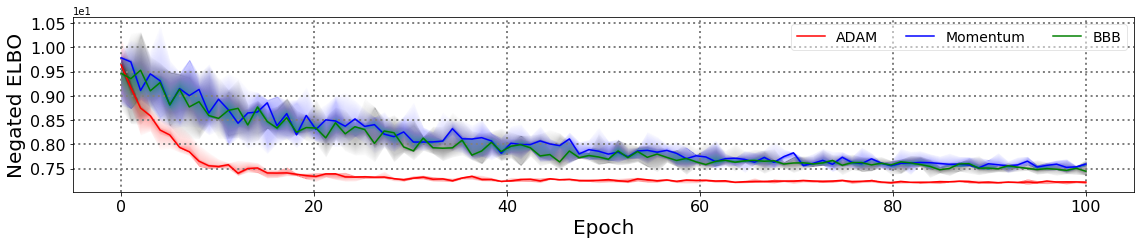

In [100]:
tsplotseveral(itera,[adam, momentum,bbb], n=100, percentile_min=2.5, percentile_max=97.5, plot_median=True, plot_mean=False, color='g', line_color='navy')

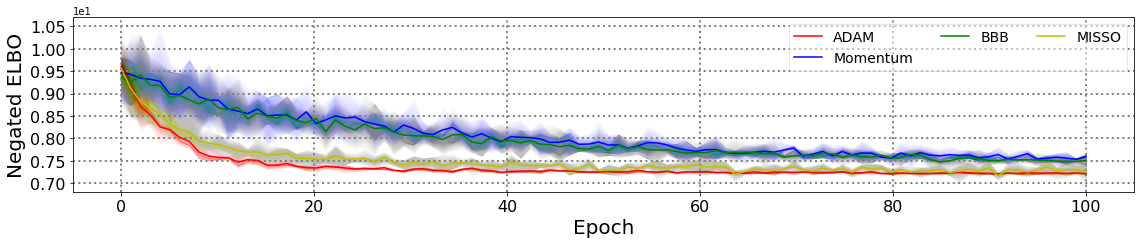

In [101]:
tsplotseveral(itera,[adam, momentum,bbb,misso], n=100)

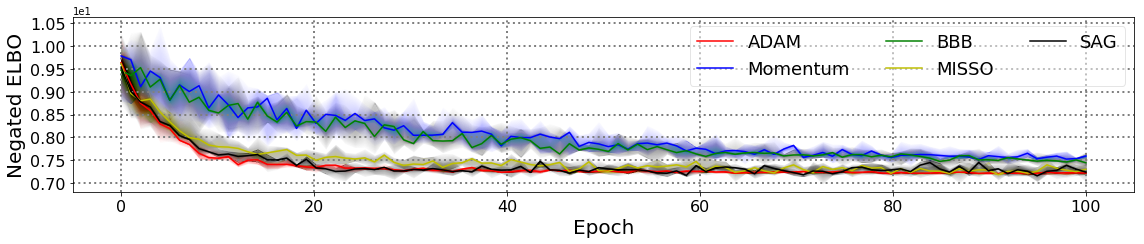

In [103]:
tsplotseveral(itera,[adam, momentum,bbb,misso,sag], n=100, percentile_min=2.5, percentile_max=97.5, plot_median=True, plot_mean=False, color='g', line_color='navy')

In [105]:
import pickle

In [106]:
with open('lossesavg/adam', 'wb') as fp: 
    pickle.dump(adam, fp)
with open('lossesavg/momentum', 'wb') as fp: 
    pickle.dump(momentum, fp)
with open('lossesavg/bbb', 'wb') as fp: 
    pickle.dump(bbb, fp)
with open('lossesavg/misso', 'wb') as fp: 
    pickle.dump(misso, fp)
with open('lossesavg/sag', 'wb') as fp: 
    pickle.dump(sag, fp)